# Linear fit with outliers, Bayesian approach

This notebook is heavily based on a <a href="http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/">post</a> from Jake Vanderplas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Generate data

Linear data with gaussian error + outliers

In [2]:
np.random.seed(33)

data_x = np.linspace(10, 100, 15) + 6*np.random.random(15)
data_y = np.linspace(30, 80, 15) + 6*np.random.random(15)
data_e = np.random.normal(5, 0.5, 15)

outlier_x = [15, 40, 100]
outlier_y = [75, 80, 50]
outlier_e = [5, 4, 6]

x = np.append(data_x, outlier_x)
y = np.append(data_y, outlier_y)
e = np.append(data_e, outlier_e)

<Container object of 3 artists>

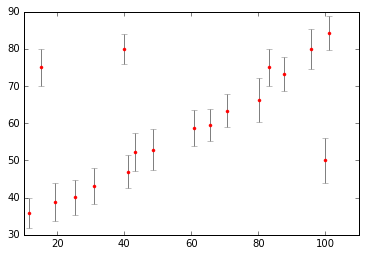

In [3]:
plt.errorbar(x, y, e, fmt='r.', ecolor='gray')

### Simple frequentist approach

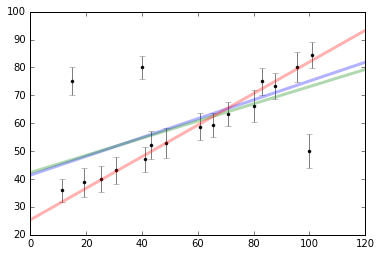

In [4]:
import scipy.stats
from scipy import optimize

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

# simple least square
theta1 = optimize.fmin(squared_loss, [25, 0.9], disp=False)
theta1_lr = scipy.stats.linregress(x, y) # without error

# scipy least_squares with huber loss
theta_ls = optimize.least_squares(squared_loss, [25, 0.9], loss='huber')

xfit = np.linspace(0, 120)
plt.errorbar(x, y, e, fmt='k.', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, 'b-', lw=3, alpha=0.3)
plt.plot(xfit, theta1_lr[1] + theta1_lr[0] * xfit, 'g-', lw=3, alpha=0.3)
plt.plot(xfit, theta_ls.x[0] + theta_ls.x[1] * xfit, 'r-', lw=3, alpha=0.3)
plt.show()

### Bayesian approach

We can modify the model so that the outliers are acounted for.

We can use a mixture between signal and background as a model (+ nuisance parameters). 

$$ p({x_i}, {y_i}, {e_i} | \theta, g_i, \sigma_B) = g_i \frac{1}{\sqrt{2 \pi e_i^2}} \exp\left[ \frac{-(\hat{y}(x_i | \theta) - y_i)^2}{2e_i^2} \right] + (1 - g_i) \frac{1}{\sqrt{2 \pi \sigma_B^2}} \exp\left[ \frac{-(\hat{y}(x_i | \theta) - y_i)^2}{2 \sigma_B^2} \right]$$

Nuisance parameters, ${g_i}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. $g_i = 0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter, or its value can be set at a sufficiently high number, say 50.

In [5]:
# theta[0] = intercept
# theta[1] = slope
# theta[2:] = g_i
def ln_prior(theta):
    if (all(theta[2:] > 0) and all(theta[2:] < 1)): # 0 < g_i < 1 
        return 0 # flat prior
    else:
        return -np.inf

def ln_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1]*x
    g = np.clip(theta[2:], 0, 1) 
    ln_L1 = np.log(g) - 0.5*np.log( 2*np.pi*e*e ) - 0.5*(dy/e)**2 
    ln_L2 = np.log(1-g) - 0.5*np.log( 2*np.pi*sigma_B*sigma_B ) - 0.5*(dy/sigma_B)**2 
    return np.sum(np.logaddexp(ln_L1, ln_L2))

def ln_posterior(theta, x, y, e, sigma_B):
    return ln_prior(theta) + ln_likelihood(theta, x, y, e, sigma_B)

In [6]:
ndim = 2 + len(x)
nwalkers = 50
nburn = 10000
nsteps = 15000

init_guess = np.zeros((nwalkers, ndim))
init_guess[:,:2] = np.random.normal(theta1, 1, (nwalkers, 2)) # near the result
init_guess[:,2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim-2)) 

In [7]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x, y, e, 50])
sampler.run_mcmc(init_guess, nsteps)

sample = sampler.chain # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/home/ridlo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/home/ridlo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


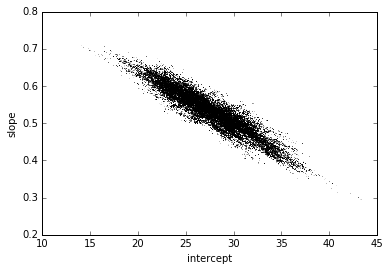

In [8]:
plt.plot(sample[:,0], sample[:,1], 'k,', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope')
plt.show()

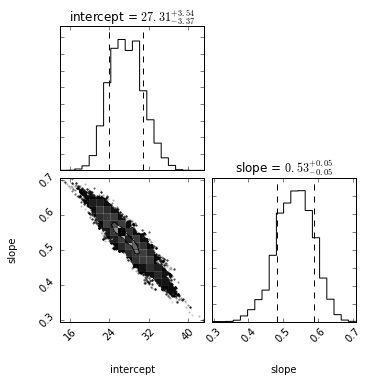

In [9]:
import corner

fig = corner.corner(sample[:,:2], labels=['intercept', 'slope'], quantiles=(0.16, 0.84), levels=(1-np.exp(-0.5),), show_titles=True, title_kwargs={"fontsize": 12})

### Outlier 

We know that the outliers are $i = 16, 17, 18$

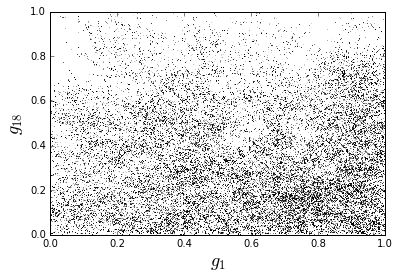

In [10]:
plt.plot(sample[:,2], sample[:,-1], 'k,', alpha=0.1)
plt.xlabel(r'$g_1$', fontsize=18)
plt.ylabel(r'$g_{18}$', fontsize=18)
plt.show()

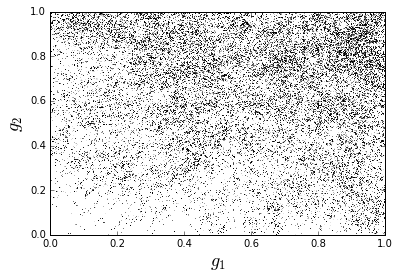

In [11]:
plt.plot(sample[:,2], sample[:,3], 'k,', alpha=0.1)
plt.xlabel(r'$g_1$', fontsize=18)
plt.ylabel(r'$g_{2}$', fontsize=18)
plt.show()

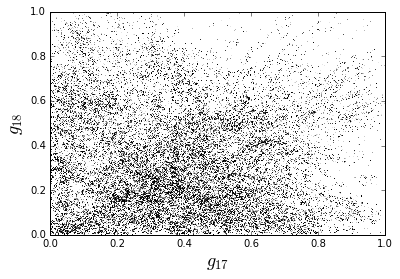

In [12]:
plt.plot(sample[:,-2], sample[:,-1], 'k,', alpha=0.1)
plt.xlabel(r'$g_{17}$', fontsize=18)
plt.ylabel(r'$g_{18}$', fontsize=18)
plt.show()

In [13]:
print 'Mean g1: ', np.mean(sample[:,2])
print 'Mean g2: ', np.mean(sample[:,3])
print 'Mean g17: ', np.mean(sample[:,-2])
print 'Mean g18: ', np.mean(sample[:,-1])

Mean g1:  0.581240434395
Mean g2:  0.635127588922
Mean g17:  0.384929827232
Mean g18:  0.323684268375


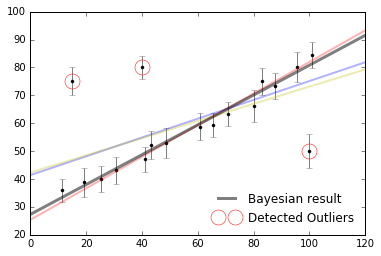

In [14]:
# chose g with mean < 0.5 as outliers
g_mean = np.mean(sample[:,2:], 0)
outliers = (g_mean < 0.5)

xfit = np.linspace(0, 120)
plt.errorbar(x, y, e, fmt='k.', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, 'b-', lw=2, alpha=0.3)
plt.plot(xfit, theta1_lr[1] + theta1_lr[0] * xfit, 'y-', lw=2, alpha=0.3)
plt.plot(xfit, theta_ls.x[0] + theta_ls.x[1] * xfit, 'r-', lw=2, alpha=0.3)

a = corner.quantile(sample[:,0], [0.5])
b = corner.quantile(sample[:,1], [0.5])

plt.plot(xfit, a + b*xfit, 'k-', lw=3, alpha=0.5, label='Bayesian result')
plt.plot(x[outliers], y[outliers], 'ro', ms=15, mfc='none', mec='red', label='Detected Outliers')
plt.legend(loc=0, frameon=False)
plt.show()